In [4]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
from os.path import expanduser

%load_ext autoreload
%autoreload 2

from dotenv import load_dotenv
load_dotenv()

from google.cloud import storage
from project_config import GCP_PROJECT_NAME, DATASET_JSON_PATH

gcp_client = storage.Client(project=GCP_PROJECT_NAME)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import os, torch
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:32" #to prevent cuda out of memory error
torch.cuda.empty_cache()


#For reproducibility
torch.manual_seed(13)

### Configuration

In [6]:
from experiment_configs.configs import *
config = testing_configC

### Create Rastervision datasets

In [7]:
from torch.utils.data import ConcatDataset
import json
from utils.rastervision_pipeline import observation_to_scene, scene_to_training_ds, scene_to_validation_ds, scene_to_inference_ds
from utils.data_management import observation_factory, characterize_dataset
import random

#set the seed
random.seed(13)

# get the current working directory
root_dir = os.getcwd()

# define the relative path to the dataset JSON file
json_rel_path = '../' + DATASET_JSON_PATH

# combine the root directory with the relative path
json_abs_path = os.path.join(root_dir, json_rel_path)

dataset_json = json.load(open(json_abs_path, 'r'))
all_observations = observation_factory(dataset_json)

#find the highest cluster id
max_cluster_id = max([observation['cluster_id'] for observation in dataset_json])


# Randomly split the data into training and validation
val_split = random.randint(0, max_cluster_id+1)

training_scenes = []
validation_scenes = []

for observation in all_observations:
    if observation.cluster_id == val_split: 
        validation_scenes.append(observation_to_scene(config, observation))
    else:
        training_scenes.append(observation_to_scene(config, observation))

# This is only for testing
if len(validation_scenes) <= 0: validation_scenes = training_scenes

training_datasets = [
    scene_to_training_ds(config, scene) for scene in training_scenes #random window sampling happens here
]
validation_datasets = [
    # scene_to_validation_ds(config, scene) for scene in validation_scenes
    scene_to_inference_ds(config, scene, full_image=False, stride=int(config.tile_size/2)) for scene in validation_scenes # better performance with this
]

train_dataset_merged = ConcatDataset(training_datasets)
val_dataset_merged = ConcatDataset(validation_datasets)

print('Validation split cluster_id:', val_split)
print ('Training dataset size: {:4d} images | Number of observations: {:}'.format(len(train_dataset_merged), len(training_scenes)))
print ('Testing dataset size: {:4d}  images | Number of observations: {:}'.format(len(val_dataset_merged), len(validation_scenes)))

mine_percentage_aoi = characterize_dataset(training_scenes, validation_scenes)

2024-01-27 09:10:23:rastervision.pipeline.file_system.utils: INFO - Downloading https://storage.googleapis.com/sand_mining_median/labels/Bhargavi_Khordha_85-88_20-26_median/s2/Bhargavi_Khordha_85-88_20-26_2018-12-01_s2.tif to /tmp/tmpbj284dpe/cache/http/storage.googleapis.com/sand_mining_median/labels/Bhargavi_Khordha_85-88_20-26_median/s2/Bhargavi_Khordha_85-88_20-26_2018-12-01_s2.tif...
2024-01-27 09:10:24:rastervision.pipeline.file_system.utils: INFO - Downloading https://storage.googleapis.com/sand_mining_median/labels/Bhargavi_Khordha_85-88_20-26_median/s1/Bhargavi_Khordha_85-88_20-26_2018-12-01_s1.tif to /tmp/tmpbj284dpe/cache/http/storage.googleapis.com/sand_mining_median/labels/Bhargavi_Khordha_85-88_20-26_median/s1/Bhargavi_Khordha_85-88_20-26_2018-12-01_s1.tif...
2024-01-27 09:10:24:rastervision.pipeline.file_system.utils: INFO - Downloading https://storage.googleapis.com/sand_mining_median/labels/Bhargavi_Khordha_85-88_20-26_median/annotations/Bhargavi_Khordha_85-88_20-26_20

Validation split cluster_id: 0
Training dataset size:   78 images | Number of observations: 3
Testing dataset size:  229  images | Number of observations: 3
Total dataset has 1.63%  mining area.
Training dataset has 1.63%  mining area.
Validation dataset has 1.63%  mining area.
Within AOIs, total dataset has 2.57%  mining area.
Outside AOIs, total dataset has 0.00%  mining area.

The median percentage of mine in an observation is 1.56%
The median number of mine pixels in an observation is 8495

The median number pixels in an observation is 522087


## Update the loss weights to account for the imbalanced dataset

In [8]:
# config.mine_class_loss_weight = (100 - mine_percentage_aoi) / mine_percentage_aoi
# config.mine_class_loss_weight = 1
config.mine_class_loss_weight

6.0

## Visualize the datasets




 Val Dataset


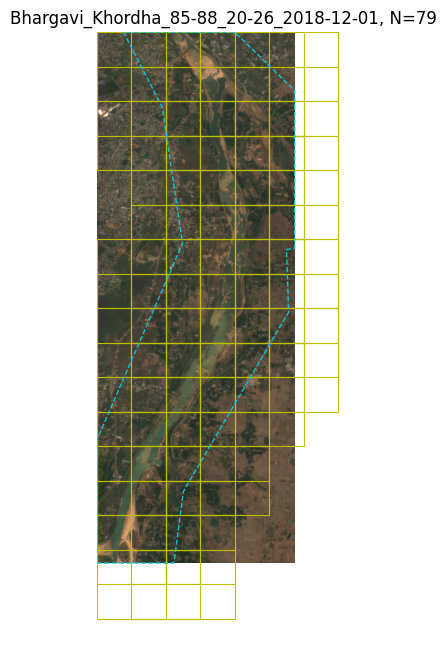

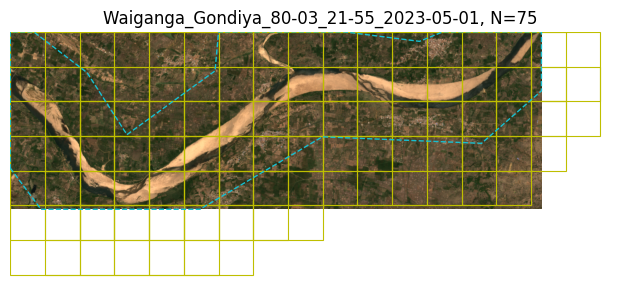

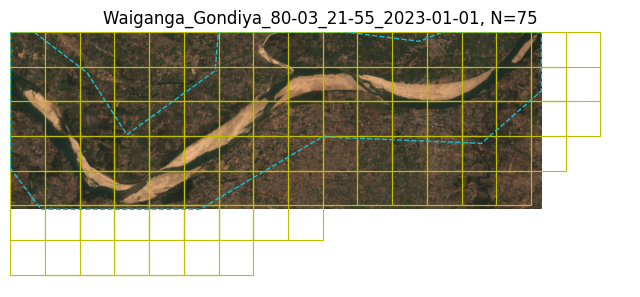

In [9]:
from utils.visualizing import visualize_dataset

# print ('Training Dataset')
# for ds in training_datasets:
#     visualize_dataset(ds)

print("\n\n\n Val Dataset")

for ds in validation_datasets:
    visualize_dataset(ds)

# Train

In [10]:
from models.model_factory import model_factory, print_trainable_parameters
from ml.optimizer_factory import optimizer_factory
from ml.learner_factory import learner_factory
from experiment_configs.schemas import ThreeClassVariants

_, _, n_channels = training_datasets[0].scene.raster_source.shape
model = model_factory(
    config,
    n_channels=n_channels
)

optimizer = optimizer_factory(config, model)

learner = learner_factory(
    config=config,
    model=model,
    optimizer=optimizer,
    train_ds=train_dataset_merged,  # for development and debugging, use training_datasets[0] or similar to speed up
    valid_ds=val_dataset_merged,  # for development and debugging, use training_datasets[1] or similar to speed up
    output_dir=expanduser("~/sandmining-watch/out/OUTPUT_DIR")
)
print_trainable_parameters(learner.model)

Number of parameters loaded: 0


2024-01-27 09:10:32:rastervision: INFO - train_ds: 78 items
2024-01-27 09:10:32:rastervision: INFO - valid_ds: 229 items


trainable params: 2.7e-05M || all params: 2.7e-05M || trainable%: 100.00


#### Check GPU Activity

You can continuously monitor your GPU activity by using the command in the terminal


`watch -d -n 0.5 nvidia-smi`

In [11]:
# Run this cell if you want to log the run to W&B. You might need to authenticate to W&B.
# learner.initialize_wandb_run()

In [12]:
learner.train(epochs=1)

2024-01-27 09:10:34:rastervision: INFO - epoch: 0


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

2024-01-27 09:11:05:rastervision: INFO - metrics:
{'avg_f1': 0.4957512319087982,
 'avg_precision': 0.9385253190994263,
 'avg_recall': 0.33683866262435913,
 'epoch': 0,
 'lc_f1': 0.0,
 'lc_precision': 0.0,
 'lc_recall': 0.0,
 'other_f1': 0.501880407333374,
 'other_precision': 0.9709264039993286,
 'other_recall': 0.3384016156196594,
 'sandmine_average_precision': 0.015449076648062162,
 'sandmine_best_f1_score': 0.03150941589967314,
 'sandmine_best_threshold': 0,
 'sandmine_f1': 0.02890286222100258,
 'sandmine_precision': 0.01479400135576725,
 'sandmine_recall': 0.6240885257720947,
 'train_ce_loss': 0.013255959902054224,
 'train_time': datetime.timedelta(seconds=9, microseconds=206392),
 'val_ce_loss': 0.008937367185234503,
 'valid_time': datetime.timedelta(seconds=21, microseconds=341744)}


Saving model weights to /home/gautam/sandmining-watch/out/OUTPUT_DIR/last-model.pth


In [29]:
output = model(train_dataset_merged[3][0].to("cuda")).to("cpu")

In [30]:
output = (output.argmax(0))

In [33]:
output.unique()

tensor([0, 2])

In [31]:
import matplotlib.pyplot as plt

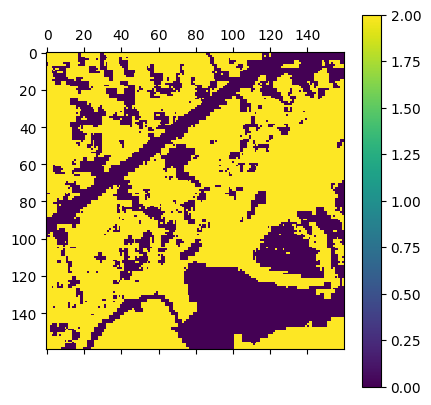

In [32]:
plt.matshow(output)
plt.colorbar()

## Evaluate 

Initialize evaluation_datasets and predictor.
evaluation_datasets and validation_datasets are based on identical scenes, but have different sliding window configurations.

In [ ]:
config = satmae_large_inf_config

In [ ]:
from ml.learner import BinarySegmentationPredictor
from utils.rastervision_pipeline import scene_to_inference_ds

evaluation_datasets =  [
    scene_to_inference_ds(
        config, scene, full_image=True
    ) for scene in validation_scenes
]

predictor = BinarySegmentationPredictor(
    config,
    model
    )


In [ ]:
from utils.visualizing import raster_source_to_rgb
from tqdm.notebook import tqdm
from ml.eval_utils import evaluate_predictions

prediction_results_list = []
# crop_sz = int(config.tile_size // 5) #20% of the tiles at the edges are discarded
crop_sz = config.crop_sz

for ds in tqdm(evaluation_datasets):
    predictions = predictor.predict_mine_probability_for_site(ds, crop_sz)

    rgb_img = raster_source_to_rgb(ds.scene.raster_source)
    prediction_results_list.append({
        "predictions": predictions,
        "ground_truth": ds.scene.label_source.get_label_arr(),
        "rgb_img": rgb_img,
        "name": ds.scene.id,
        "crop_sz": crop_sz,
    })

evaluation_results_dict = evaluate_predictions(prediction_results_list)

## Pick the threshold that maximizes F1 score

In [ ]:
threshold = evaluation_results_dict['eval/total/best_threshold']
threshold

In [ ]:
evaluation_results_dict


Log results to Weights & Biases

In [ ]:
import wandb
from ml.eval_utils import make_wandb_segmentation_masks, make_wandb_predicted_probs_images

assert wandb.run is not None

# Add lists of W&B images to dict
evaluation_results_dict.update({
    'Segmentation masks': make_wandb_segmentation_masks(prediction_results_list, threshold),
    'Predicted probabilites': make_wandb_predicted_probs_images(prediction_results_list),
})

# Log to W&B
wandb.log(evaluation_results_dict)

In [ ]:
wandb.finish()